In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

/home/vlad/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [2]:
diamonds_df = pd.read_csv('diamonds.csv')

In [3]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


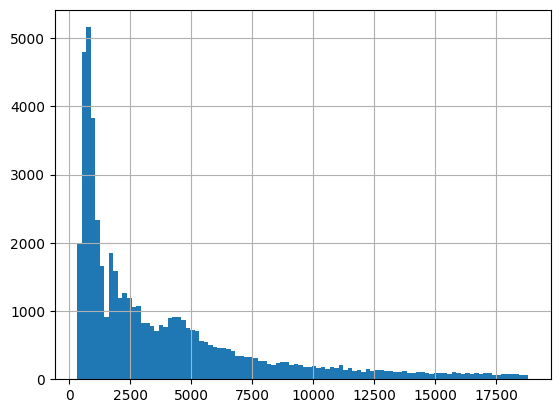

In [4]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [5]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [6]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [7]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [8]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [9]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

In [11]:
y_train

array([[ 1013],
       [17360],
       [ 1440],
       ...,
       [ 1853],
       [ 2333],
       [ 1009]])

# Обучаем модель линейной регрессии

In [12]:
reg = LinearRegression().fit(X_train, y_train)

In [13]:
X_train[0].T

array([0.05197505, 0.75      , 0.83333333, 0.85714286, 0.55555556,
       0.25      , 0.45623836, 0.08285229, 0.09685535])

In [14]:
y_pred = reg.predict(X_test)

In [15]:
score = r2_score(y_pred, y_test)

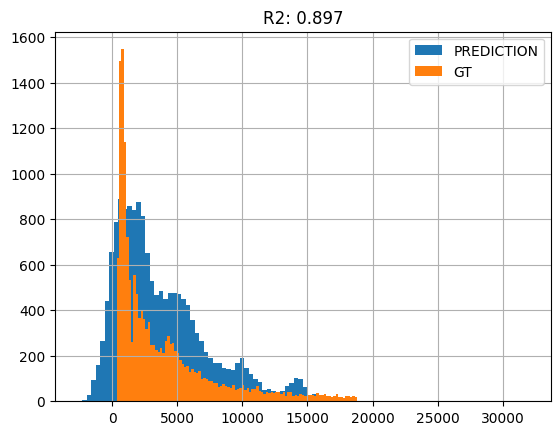

In [16]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [1930]:
class MLPRegressor:
    def __init__(
        self,
        hidden_layer_sizes=(100,),
        learning_rate=1e-9,
        max_iter=10,
        batch_size=100
    ):
        self.hidden_sizes = hidden_layer_sizes
        self.depth = len(hidden_layer_sizes)
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.weights = []
        self.biases = []
    
    def activation(self, layer):
        # return np.where(layer > 0, layer, 0)
        return 1 / (1 + np.exp(-layer))
        # return layer
    
    # выражает производную функции активации через саму функцию активации
    def derivative(self, layer):
        return layer * (1 - layer)
        # return np.where(layer, 1, 0)
        # return layer * (1 - layer)
        # return np.ones_like(layer)
    
    def train(self, X, y):
        input_size = X.shape[1]
        output_size = y.shape[1]

        layer_sizes = tuple([input_size] + list(self.hidden_sizes) + [output_size])

        if not self.weights:
        # инициализация весов и смещений
            for i in range(self.depth + 1):
                # W = np.random.normal(0, 0.1, size=(layer_sizes[i + 1], layer_sizes[i]))
                W = np.random.random(size=(layer_sizes[i + 1], layer_sizes[i]))
                b = np.zeros(layer_sizes[i + 1]).reshape(1, -1)
                self.weights.append(W)
                self.biases.append(b)
        
        
        X_batches = np.array_split(X, X.shape[0] // self.batch_size)
        y_bathes = np.array_split(y, y.shape[0] // self.batch_size)

        for epoch in range(self.max_iter):
            for k in range(len(X_batches)):
                X_batch = X_batches[k]
                # print(X_batch.shape)
                y_batch = y_bathes[k]
                # print(y_batch.shape)

                layers = [X_batch]
                for i in range(self.depth):
                    h = layers[-1] @ self.weights[i].T + self.biases[i]
                    h = self.activation(h)
                    layers.append(h)
                
                y_pred_batch = layers[-1] @ self.weights[-1].T + self.biases[-1]
                # print('Loss:', ((y_pred_batch - y_batch)**2).sum() / self.batch_size)

                grad = 2 / len(X_batch) * (y_pred_batch - y_batch)
                for i in range(self.depth + 1):
                    grad_W = grad.T @ layers[-1 - i]
                    grad_b = np.ones((1, len(X_batch))) @ grad
                    grad = (grad @ self.weights[-1 - i]) * self.derivative(layers[-1 - i])

                    self.weights[-1 - i] -= grad_W * self.learning_rate
                    self.biases[-1 - i] -= grad_b * self.learning_rate

    
    def predict(self, X):
        for i in range(len(self.weights)):
            X = X @ self.weights[i].T + self.biases[i]
        return X

In [18]:
def objective(trial):
    hidden = trial.suggest_int('hidden_size', 100, 100)
    max_iter = trial.suggest_int('iter', 10, 10)
    learning_rate = trial.suggest_float('lr', 1e-7, 1e-3)
    batch_size = trial.suggest_int('batch_size', X_train.shape[0], X_train.shape[0])

    model = MLPRegressor(hidden_layer_sizes=(hidden,), max_iter=max_iter, 
                         learning_rate=learning_rate, batch_size=batch_size)
    model.train(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_pred, y_test)
    return score

In [19]:
study = optuna.create_study(direction='maximize')  # Укажите 'maximize', если вы хотите максимизировать метрику
study.optimize(objective, n_trials=1)

[I 2023-09-18 00:27:52,226] A new study created in memory with name: no-name-40b5f248-64e6-42f0-bda4-b416d94bbce9
[I 2023-09-18 00:27:53,973] Trial 0 finished with value: -66.01704058748628 and parameters: {'hidden_size': 100, 'iter': 10, 'lr': 0.0009537391712216269, 'batch_size': 37758}. Best is trial 0 with value: -66.01704058748628.


In [20]:
study.best_params

{'hidden_size': 100,
 'iter': 10,
 'lr': 0.0009537391712216269,
 'batch_size': 37758}

In [21]:
np.random.random(size=(3,4)) * 0.1

array([[0.08176583, 0.06503007, 0.08695112, 0.02429181],
       [0.07108797, 0.07522343, 0.06212179, 0.09050343],
       [0.05912967, 0.00282895, 0.08673715, 0.02371296]])

In [22]:
X_train.shape[0] // (X_train.shape[0] // 920)

920

In [1940]:
model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=4000, 
                        learning_rate=1e-8, batch_size=1)
# model.max_iter = 30
# model.learning_rate = 1e-3
model.train(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_pred, y_test)
score

-1.053298961974804

In [1941]:
from copy import deepcopy

In [1942]:
savedw1 = deepcopy(model.weights)
savedb1 = deepcopy(model.biases)

# Проверяем модель MLP на выборке Diamonds

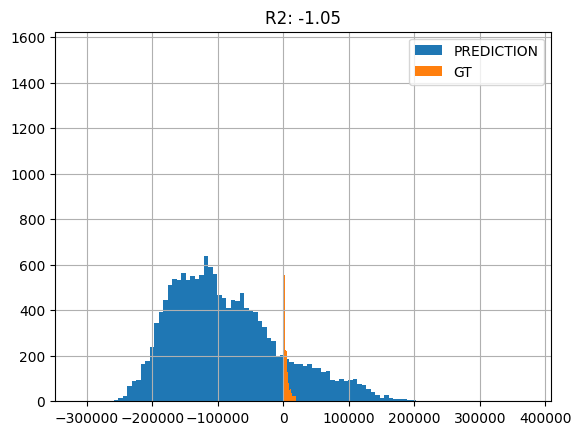

In [1943]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

In [1944]:
model.train(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_pred, y_test)
score

-0.968782315982643

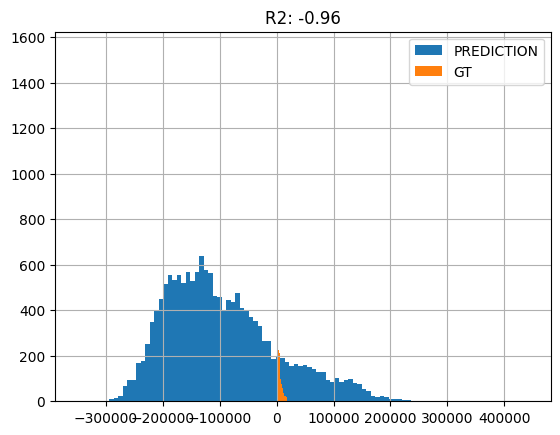

In [1945]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

In [1946]:
savedw2 = deepcopy(model.weights)
savedb2 = deepcopy(model.biases)

In [1947]:
model.train(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_pred, y_test)
score

-0.9404140731545587